# Introduction to QAOA and Graph Coloring

What are we covering in this section:
- What you will need to run the examples in this script
- What is the QAOA algorithm
- What problems can it solve (what is QUBO)?
- Example of graph coloring
- Suggestions of other problems to try (and real world use cases)

## Getting set up

First, we'll import the necessary Julia and Python packages. All the examples in this notebook are run by default on the local simulator, so you won't incur any charges.

In [1]:
using Pkg
Pkg.add("LightGraphs")
Pkg.add("GraphPlot")
Pkg.add("Colors")
Pkg.add("Cairo")
Pkg.add("Compose")
Pkg.add("NLopt")
Pkg.add("PyCall")
Pkg.build("PyCall")
Pkg.add("AWS")
using LightGraphs, GraphPlot, Colors, Cairo, Compose # generating and displaying graphs
using NLopt # we will use NLopt to update the variational parameters in QAOA
using PyCall # to call the Braket SDK
using AWS: @service
using LinearAlgebra
using SparseArrays

# we'll need this in case we want to use the managed simulators
@service S3
@service Braket
@service STS;

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environ

In [2]:
# Braket imports
awsbraket = pyimport("braket.aws")
circuit   = pyimport("braket.circuits")
devices   = pyimport("braket.devices");

## Why color graphs?
 
Many optimization problems in the real world can be modeled in terms of "graph coloring". In such a problem, we have a set of vertices connected by edges (a graph) and would like to place each vertex in one of a set of bins such that no adjacent vertices are in the same bin. You might have heard of this problem in the context of coloring a map - we don't want neighboring countries on a map to have the same color or it will be hard to tell them apart. But there are other problems that are naturally expressible as a graph coloring problem, such as:
- Scheduling tasks to run on GPU workers
- Creating exam schedules for university students
- Assigning gates to aircraft at the airport
- In general, any scheduling problem in which many clients/workers (students, CPU threads, airplanes) contend for scarce resources (exam slots, exclusive control over a GPU, aircraft gates) and conflicts may occur (simultaneous exams, threads getting blocked, planes running into each other)

## QAOA: what, how, and why

There are many existing algorithms developed to solve graph coloring problems. Why would we want another?

The quantum approximate optimization algorithm (QAOA) was developed to make use of near term quantum devices. Quantum computers today don't have a large number of qubits, but we would still like to use them to solve real-world problems. QAOA is based on the concept of *hybrid computations* -- accelerating a classical workload using a quantum processor. Similar to computing using a GPU or TPU, we hope to offload the hard part of the computation to a quantum device which acts as an accelerator.

QAOA is designed to solve "QUBO" problems: quadratic unconstrained binary optimization. A QUBO problem is one that can be formulated as:

Find the vector `y` which minimizes `z^T Q z`.

`Q` is a matrix which encodes the optimization problem. To understand the basics of QAOA, let's start with a quantum formulation of the QUBO form above by replacing `z^T Q z` with a Hamiltonian `H` such that:

$\hat{H} = \sum_{i,j} J_{i,j} \hat{\sigma}^z_i \hat{\sigma}^z_j$

The sum runs over all pairs of sites in the system. This is an Ising model of magnetism of quantum spins, and we can use a quantum computer to solve it. If we find the ground state of this quantum system we have solved the associated QUBO problem. The ground state is the eigenvector of the matrix `H` associated with the lowest-lying eigenvalue. QAOA attempts to do this by applying a series of circuits, each of which takes a variational parameter, and optimizing the parameters.

In QAOA we apply two sub-circuits in each layer: the "cost" circuit and the "driver" circuit. The cost circuit has parameter γ associated with it, and the driver has parameter β. We'll first build a generic interface to create the cost and driver circuits:

In [3]:
function ZZgate(q1, q2, γ)
    circ_zz = circuit.Circuit()
    circ_zz.add(circuit.Circuit().cnot(q1, q2))
    circ_zz.add(circuit.Circuit().rz(q2, γ))
    circ_zz.add(circuit.Circuit().cnot(q1, q2))
    return circ_zz
end

function cost_circuit(γ, nqubits, device, ising)
    cost    = circuit.Circuit()
    I, J, V = findnz(sparse(ising))
    for (i, j, int) in zip(I, J, V)
        if i != j
            if device.name == "Rigetti"
                cost.add(ZZgate(i-1, j-1, γ*int))
            else
                cost.add(circuit.Circuit().zz(i-1, j-1, -2γ*int))
            end
        end
    end
    return cost
end

function driver_circuit(β, nqubits)
    driver = circuit.Circuit()
    for qubit in 1:nqubits
        driver.add(circuit.Circuit().rx(qubit-1, 2β))
    end
    return driver
end

function qaoa_circuit(params, device, nqubits, ising)
    depth = div(length(params), 2)
    γs    = params[depth+1:end]
    βs    = params[1:depth]

    circ = circuit.Circuit()
    circ.add(circuit.Circuit().x(0:nqubits-1))
    circ.add(circuit.Circuit().h(0:nqubits-1))

    for layer in 1:depth
        cost_circ = cost_circuit(γs[layer], nqubits, device, ising)
        circ.add(cost_circ)
        driver_circ = driver_circuit(βs[layer], nqubits)
        circ.add(driver_circ)
    end
    return circ
end

qaoa_circuit (generic function with 1 method)

We then *train* the variational parameters. For a QAOA circuit with `n` layers, we have `2n` variational parameters: `n` β for the drivers and `n` γ for the costs. We'll use `NLOpt.jl` to perform the optimization of these parameters. This `train` function can be used for any Ising Hamiltonian that describes a QUBO problem -- we just need to generate an appropriate Hamiltonian.

In this case we will use the `DefaultSimulator`, which is free. The number of qubits we'll need to solve the problem is `nv * k`, where `nv` is the number of vertices in the graph and `k` is the number of colors. The `DefaultSimulator` runs locally on hardware you control (e.g. your laptop) and as such will only be efficient up to about 18 qubits or so on most personal computers. For this reason, we'll look at graphs with 6 vertices and try to color them with 3 colors. If you want to try larger graphs and/or more colors, some options are:

- Try with only 2 colors and use more qubits
- Run the training for longer -- more qubits will take more time & memory
- Switch from the local default simulator to one of Braket's managed simulators
- Run the local simulator on a computer with more RAM

### Building a training function

In this section, we'll build a function to train the variational parameters $\beta$ and $\gamma$ for each layer of the QAOA circuit using `NLopt.jl` and the input Ising Hamiltonian we generate. Our training function will be *agnostic* of the specific Hamiltonian, so we can worry about generating one appropriate to our specific problem later on.

To write the training function, we'll need:
- a function `f` which takes arguments `params` and `grad` (`params` will be variational parameters $\beta$ and $\gamma$)
- a way to initialize our parameters
- a way to compute losses at each training step
- a way to track the losses and current best solution at each training iteration

In [4]:
# initializing the optimization
function init_opt(qaoa_depth::Int, n_qubits::Int)
    global_min   = 1e8
    global_state = zeros(n_qubits)
    # initialize with random parameters
    βs           = rand(qaoa_depth)
    γs           = rand(qaoa_depth)
    params       = vcat(βs, γs)
    # tracker for optimization process
    tracker      = Dict("costs"=>[],
                        "params"=>[],
                        "optimal_energy"=>global_min, # best energy so far
                        "optimal_state"=>global_state, # best configuration so far
                        "opt_energies"=>Float64[], # track lowest eigenvalue at every iteration
                        "opt_states"=>[] # track configuration associated with lowest eigenvalue at every iteration
                        )
    return params, tracker
end

init_opt (generic function with 1 method)

In [5]:
# generating the loss & finding the best configuration at each iteration
function apply_qaoa(qaoa_circ, ising, device, nshots::Int)
    task = device.run(qaoa_circ, shots=nshots)
    # the managed simulators store results in Amazon S3
    #    task = device.run(qaoa_circ, s3_folder, nshots)

    # matrix of dimension (nshots, num_qubits)
    result     = task.result()

    # result comes back as 0s and 1s
    meas_ising = result.measurements
    # but Ising hamiltonian expects values of -1 or 1
    meas_ising = map( x -> x == 0 ? -1 : 1, meas_ising)

    # generate the energies
    g   = diag(ising)
    J   = triu(ising, 1)
    xQx = diag(meas_ising * J * transpose(meas_ising)) # computes <x | Q | x> for every result configuration
    gx  = sum(Diagonal(g) * transpose(meas_ising), dims=1)
    gx  = vec(gx)
    all_energies = xQx + gx
    loss = sum(all_energies) / nshots

    # select the best energy
    energy_min    = minimum(all_energies)
    # find the configuration that had that energy
    min_index     = findfirst(x->x==energy_min, all_energies)
    optimal_state = meas_ising[min_index, :]

    return loss, energy_min, optimal_state
end

apply_qaoa (generic function with 1 method)

In [6]:
function train(nqubits::Int, ising, device; depth::Int=3, iterations::Int=100, nshots::Int=1000, s3_folder=nothing)
    params, tracker = init_opt(depth, nqubits)
    function f(params, grad)
        # create the circuit
        qaoa_circ = qaoa_circuit(params, device, nqubits, ising)
        loss, energy_min, optimal_state = apply_qaoa(qaoa_circ, ising, device, nshots)
        
        # update the tracker
        push!(tracker["opt_energies"], energy_min)
        push!(tracker["opt_states"],    optimal_state)
        if energy_min < tracker["optimal_energy"]
            tracker["optimal_energy"] = energy_min
            tracker["optimal_state"]  = optimal_state
        end
        tracker["count"] = tracker["count"] + 1
        push!(tracker["params"], params)
        

        push!(tracker["costs"], loss)
        return loss
    end

    opt = Opt(:LN_COBYLA, length(params))
    min_objective!(opt, f)
    maxeval!(opt, iterations)
    for i in 1:iterations
        loss, params, info = optimize(opt, params)
    end
    return tracker
end

train (generic function with 1 method)

Now that we have a generic training function we can use to perform QAOA in Julia, we can turn our attention to generating the specific Ising Hamiltonian we'll need to encode the graph coloring problem we would like to solve. Again, our training function is *not unique* and could be deployed with any QUBO problem.

Now we can use `LightGraphs.jl` to generate a random graph and try to color it. We'll start off with 6 vertices and 3 colors so that the problem is tractable using the `LocalSimulator`:

In [7]:
nv = 6 #number of vertices
ne = 7 #number of edges
k  = 3 #number of colors
G  = erdos_renyi(nv, ne)

{6, 7} undirected simple Int64 graph

Let's produce a visualization of the graph so we can get some intuition for what a solution could look like:

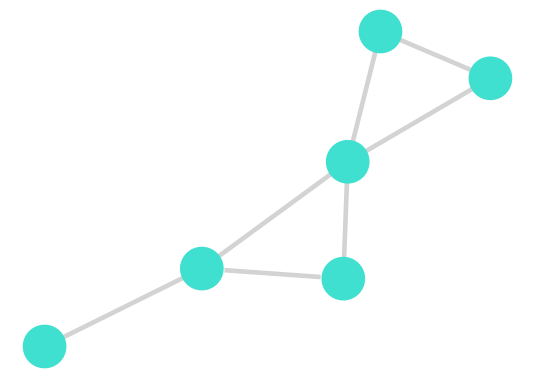

In [8]:
gplot(G)

## Generating a Hamiltonian for a QUBO problem
Now we need to generate an Ising Hamiltonian to represent the constraints in the problem. In order to color the graph with `k` colors, each vertex should have a different color from all its neighbors. Thus we will encode the problem in `nv * k` variables `x_{v,q}` - each one encodes whether the vertex `v` has color `q`.

For example, if we have 4 colors and two vertices, then `{x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8} = {1, 0, 0, 0, 0, 0, 1, 0}` would mean that we had colored the first vertex with color 1 and the second with color 3. The first four variables encode the presence of each of the 4 colors on the first vertex.

We'll determine the final values of these variables by representing them as qubits and performing the QAOA algorithm. We have two sets of constraints to combine:
1. Each vertex must have one color - ($x_{v,1} + x_{v,2} + \ldots + x_{v,k}$ = 1)
2. Adjacent vertices must have different colors ($x_{v,q} + x_{w,q} \leq 1$ iff $v, w$ are adjacent)

We'll encode the constraints into an `nv * k` by `nv * k` matrix that will serve as the Hamiltonian for QAOA. By finding the lowest lying eigenstate of this Hamiltonian using the training function we already wrote, we will solve the problem.

Where does the "quadratic" part arise? Following [](http://leeds-faculty.colorado.edu/glover/511%20-%20QUBO%20Tutorial%20-%20updated%20version%20-%20May%204,%202019.pdf), we want to solve:

$ min y = x^T C x $

$ Ax = b $

given that `x` is equal to either `0` or `1`. Then we can notice that:

$ (Ax - b) = 0 $

$ (Ax - b)^T (Ax - b) = 0 $

Thus, if `x` can only take values `0` or `1`, we can make the problem quadratic by computing this product to generate:

$ min y = x^T C x + P_1 (Ax - b)^T (Ax - b) $

$ min y = x^T C x + x^T B x + c $

$ min y = x^T Q x + c$

This will represent the optimization problem before we account for the constraints from the adjacency rules. We pick a "penalty" for each constraint (`P1` and `P2`). These penalties are arbitrary. In our case, we need to compute:
$P_1 (x - 1)^T(x - 1)$

In [9]:
# enforce that each vertex has only one color
P1 = 8
# add the P1 (x_{v,1} + ... + x_{v, k} - 1)^2 constraint
J  = Matrix(Diagonal(fill(P1,nv*k)))
for v in 1:nv # for each vertex
    for i in 1:k 
        for j in i+1:k
            J[k*(v-1) + i, k*(v-1) + j] = P1
            J[k*(v-1) + j, k*(v-1) + i] = P1
        end
    end
end
J

18×18 Matrix{Int64}:
 8  8  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 8  8  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 8  8  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  8  8  8  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  8  8  8  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  8  8  8  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  8  8  8  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  8  8  8  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  8  8  8  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  8  8  8  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  8  8  8  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  8  8  8  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  8  8  8  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  8  8  8  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  8  8  8  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  8  8
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  8  8
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  8  8

Now we handle the second set of constraints: $P_2x_ix_j$ if the vertices associated with $x_i$ and $x_j$ are adjacent.

In [10]:
# enforce that adjacent vertices have different colors
# add the penalty P2 x_{v,q}x_{w,q} for adjacent vertices v, w and all colors q
P2 = 8
adj_mat = adjacency_matrix(G)
iis, jjs, V = findnz(triu(adj_mat))
for (i,j) in zip(iis, jjs)
    for color in 1:k
        J[k*(i-1) + color, k*(j-1) + color] = P2/2
        J[k*(j-1) + color, k*(i-1) + color] = P2/2
    end
end
J

18×18 Matrix{Int64}:
 8  8  8  0  0  0  4  0  0  4  0  0  4  0  0  4  0  0
 8  8  8  0  0  0  0  4  0  0  4  0  0  4  0  0  4  0
 8  8  8  0  0  0  0  0  4  0  0  4  0  0  4  0  0  4
 0  0  0  8  8  8  0  0  0  0  0  0  4  0  0  0  0  0
 0  0  0  8  8  8  0  0  0  0  0  0  0  4  0  0  0  0
 0  0  0  8  8  8  0  0  0  0  0  0  0  0  4  0  0  0
 4  0  0  0  0  0  8  8  8  0  0  0  0  0  0  4  0  0
 0  4  0  0  0  0  8  8  8  0  0  0  0  0  0  0  4  0
 0  0  4  0  0  0  8  8  8  0  0  0  0  0  0  0  0  4
 4  0  0  0  0  0  0  0  0  8  8  8  4  0  0  0  0  0
 0  4  0  0  0  0  0  0  0  8  8  8  0  4  0  0  0  0
 0  0  4  0  0  0  0  0  0  8  8  8  0  0  4  0  0  0
 4  0  0  4  0  0  0  0  0  4  0  0  8  8  8  0  0  0
 0  4  0  0  4  0  0  0  0  0  4  0  8  8  8  0  0  0
 0  0  4  0  0  4  0  0  0  0  0  4  8  8  8  0  0  0
 4  0  0  0  0  0  4  0  0  0  0  0  0  0  0  8  8  8
 0  4  0  0  0  0  0  4  0  0  0  0  0  0  0  8  8  8
 0  0  4  0  0  0  0  0  4  0  0  0  0  0  0  8  8  8

Now we will run the QAOA algorithm on this graph and attempt to color it. At the end of the optimization we'll print out a trace of the best energy found at each step and a numerical representation of the solution:

In [11]:
DEPTH   = 2
SHOTS   = 1000


device  = devices.LocalSimulator()
# uncomment this to use the managed state vector simulator if you have an AWS account - note that you may be charged!
#device  = awsbraket.AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
#bucket  = # your s3 bucket here
#folder  = "graph-coloring"

tracker = train(nv*k, J, device; depth=DEPTH, nshots=SHOTS) #s3_folder = (bucket, folder) if using managed simulator
@show tracker["opt_energies"]
@show tracker["optimal_energy"]
@show tracker["optimal_state"]


tracker["opt_energies"] = [-100.0, -124.0, -108.0, -108.0, -100.0, -116.0, -116.0, -108.0, -108.0, -100.0, -116.0, -108.0, -108.0, -116.0, -100.0, -108.0, -100.0, -124.0, -108.0, -116.0, -116.0, -116.0, -100.0, -116.0, -100.0, -100.0, -116.0, -116.0, -108.0, -108.0, -108.0, -100.0, -116.0, -108.0, -116.0, -108.0, -116.0, -108.0, -100.0, -100.0, -100.0, -116.0, -116.0, -116.0, -108.0, -108.0, -116.0, -116.0, -108.0, -116.0, -100.0, -100.0, -116.0, -116.0, -100.0, -100.0, -108.0, -100.0, -108.0, -108.0, -116.0, -100.0, -116.0, -100.0, -100.0, -116.0, -124.0, -100.0, -116.0, -116.0, -116.0, -116.0, -116.0, -116.0, -108.0, -108.0, -116.0, -116.0, -116.0, -116.0, -116.0, -116.0, -108.0, -100.0, -116.0, -116.0, -116.0, -108.0, -108.0, -100.0, -108.0, -100.0, -108.0, -100.0, -100.0, -100.0, -100.0, -124.0, -116.0, -108.0]
tracker["optimal_energy"] = -124
tracker["optimal_state"] = [-1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1]


18-element Vector{Int64}:
 -1
  1
 -1
 -1
  1
 -1
 -1
 -1
  1
  1
 -1
 -1
 -1
 -1
  1
  1
 -1
 -1

Now we can apply the coloring solution generated by QAOA to our initial graph and see how well it did:

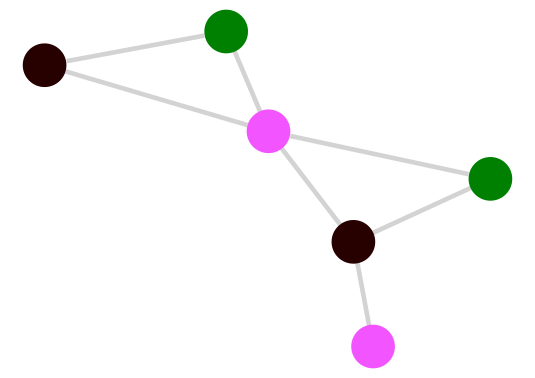

In [12]:
opt_state = tracker["optimal_state"]
nodefillc = distinguishable_colors(k, colorant"green")
color_inds = zeros(Int, nv)
for v in 1:nv
    color_inds[v] = Int(findfirst(x->x>0, opt_state[(k*(v-1) + 1):k*v]))
end
gplot(G, nodefillc=nodefillc[color_inds])

## Summing up

What we covered in this section:
- Many important optimization problems can be formulated in a quantum unconstrained binary optimization (QUBO) format
- These QUBO problems are amenable to acceleration with a hybrid classical-quantum approach.
- One such hybrid algorithm is QAOA, which we implemented above

This is a lot to take in! If it doesn't all make sense, try going through the procedure outlined above for another QUBO-type problem (max cut is a good choice, as it's a special case of graph colouring).

You might well ask, what's the point of doing all this for so few qubits? After all, extremely effective classical eigensolvers exist which could have easily found the groundstate of our Hamiltonian! For the size of problem we are considering, this is indeed true. However, we know that beyond a certain size, eigensolving is intractable even on the most advanced classical supercomputers. Our hope with algorithms like QAOA is to find techniques to make effective use of near term quantum devices (which have few qubits available), understand their performance and limitations, and prepare for a future in which we will have quantum computers with many hundreds or even thousands of qubits.

### Suggestions for further exploration:
- How does the number of shots or number of layers (depth) affect the results?
- Try different types of random graphs. You can find a list of available generators in the [LightGraphs documentation](https://juliagraphs.org/LightGraphs.jl/latest/).
- Try a different QUBO problem. You can find a list of canonical examples and formulae for generating Hamiltonians from them [in this tutorial](http://leeds-faculty.colorado.edu/glover/511%20-%20QUBO%20Tutorial%20-%20updated%20version%20-%20May%204,%202019.pdf). Some suggestions are:
  - Minimum vertex cover
  - Quadratic knapsack problem
  - Max clique (you can find a formulation of this problem as QUBO [here](https://arxiv.org/pdf/1801.08649.pdf))
- Check out the [Amazon Braket QAOA tutorial](https://github.com/aws/amazon-braket-examples/blob/main/examples/hybrid_quantum_algorithms/QAOA/QAOA_braket.ipynb) for more examples
- There are graph colouring encodings for QAOA which use fewer than `nv * k` qubits -- see [this paper](https://arxiv.org/pdf/2009.07314.pdf) for an example. Can you implement their technique?